# Лабораторная работа 1
Средства автоматизации расчетов и моделироаания систем управления в среде Python/scipy

### Модель системы

$\dot P = - P^3 + dm + v(t)$

$\dot dm = -dm + G \, tanh(\omega)$

### 1. Автоматизация расчета закона управления с помощью пакета sympy

In [9]:
import sympy

P=sympy.symbols('P')
dm=sympy.symbols('dm')
G=sympy.symbols('G')
w=sympy.symbols('w')
Pd=sympy.symbols('Pd')
v=sympy.symbols('v')
v0=sympy.symbols('v0')

dP=-P**3 + dm + v + v0
ddm=-dm + G * w

print('Уравнения системы:')
print('dP/dt=' + str(dP))
print('ddm/dt=' + str(ddm))
print('')

Уравнения системы:
dP/dt=-P**3 + dm + v + v0
ddm/dt=G*w - dm



$\dot P_d = P_d - P$

$\dot P - \dot P_d = 0$

In [10]:
from sympy.solvers import solve
DdP=Pd-P
Ddm=solve(dP-DdP,dm)
print('Желаемая функция dm(t) для эталонной модели dP='+str(DdP))
print('dm='+str(Ddm))
print('')

Желаемая функция dm(t) для эталонной модели dP=-P + Pd
dm=[P**3 - P + Pd - v - v0]



In [11]:
psi=Ddm[0]-dm
dpsi=sympy.diff(psi,P)*dP + sympy.diff(psi,dm)*ddm
u=solve(sympy.expand(dpsi+psi),w)
u_analytical = u[0]
print('Закон управления по методу АКАР для макропеременной psi=' + str(psi))
print('w='+str(u_analytical))
print()

Закон управления по методу АКАР для макропеременной psi=P**3 - P + Pd - dm - v - v0
w=(-3*P**5 + 2*P**3 + 3*P**2*dm + 3*P**2*v + 3*P**2*v0 - P + Pd - dm - 2*v - 2*v0)/G



### 2. Численное моделирование системы ОДУ

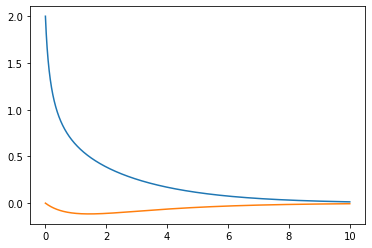

In [12]:
import matplotlib.pyplot as plt 
import scipy.integrate as mdl 
import math
import numpy as np

u = 20.0
x0d = 3.0
def F(x, t):
    return [-math.pow(x[0],3)+x[1], -x[1]+0.25*math.tanh(-1.0*x[0])] 

u = 5.0
t = np.linspace(0, 10, 10000)
y = mdl.odeint(F, [2.0, 0.0], t)

plt.plot(t,y)
plt.show()

In [13]:
print(t)

[0.00000000e+00 1.00010001e-03 2.00020002e-03 ... 9.99799980e+00
 9.99899990e+00 1.00000000e+01]


### 3. Моделирование САУ с цифровым ПИ-регулятором


Базовый класс для моделирования контроллера

In [14]:
import math
import numpy

class PLC:
    def __init__(self, gain, step):
        self.last_t = 0.0
        self.last_call_t = 0.0
        self.last_u = 0
        self.step = step
        self.last_e = 0.0
        self.gain = gain
        self.u = []
        self.ulim = []
        self.t = []
        
    def getLimitedOutput(self,value):
        return math.tanh(value)
        
    def addOutputValue(self,time,value):
        self.t.append(time)
        self.u.append(value)
        self.ulim.append(self.getLimitedOutput(value))
        
    def output(self, x, t):
        self.addOutputValue(t, self.last_u)
        self.last_u = self.control(x, t)
        self.last_t = t
        self.addOutputValue(t,self.last_u)
        
        return self.gain*self.ulim[-1]

def calculate(func, x0, step, time, plc):
    result = {'t': [], 'u':[]}
    for i in range(0,len(x0)):
        result['x' + str(i + 1)] = []
    rstep = plc.step
    ode_step = step
    timev = numpy.linspace(0.0, time, int(time/rstep+1))
    for ti in timev:
        uk = plc.output(x0, ti)
        tk = np.linspace(ti, ti+rstep, int(rstep/ode_step+1))
        y = mdl.odeint(func(uk), x0, tk)
        x0 = y[-1]
        result['t'].extend(tk[:-1])
        for i in range(0,len(x0)):
            result['x' + str(i + 1)].extend(y[:-1,i])
        result['u'].extend([uk for i in tk[:-1]])
    return result


Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [15]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                v0 = finish_value
            else:
                v0 = init_value
            return [ -math.pow(x[0],3) + x[1] + v0, -x[1] + uc] 
    
        return F_internal
    return F_with_control

Реализация алгоритма ПИ-регулирования

In [16]:
class PI(PLC):
    def __init__(self, goal, Kp, Ki, gain, step):
        super(PI,self).__init__(gain, step)
        self.Ki = Ki
        self.Kp = Kp
        self.goal = goal
        self.ei = 0
    
    def control(self, x, t):
        e = x[0] - self.goal
        self.ei = self.ei + e        
        return self.Kp * e + self.Ki * self.ei

Вывод результатов моделирования

In [17]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-') 
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--') 
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.ulim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')  
    plt.show()

Программа моделирования

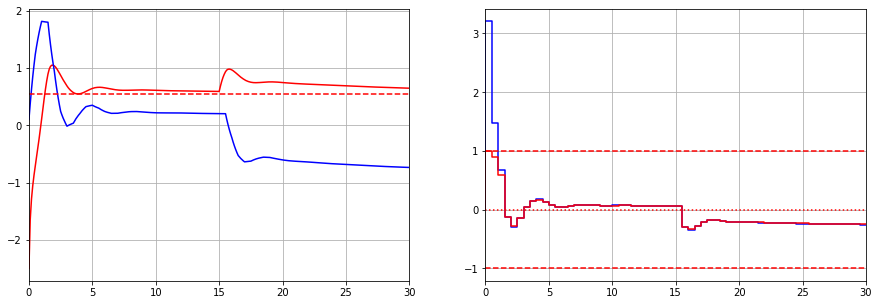

In [18]:
v0_init = 0.0
v0_finish = 1.0
change_time = 15
goal = 0.55
gain = 3.0
step = 0.5
mod_step = 0.1
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc=PI(goal=goal, Kp=-1.0, Ki=-0.05, gain=gain, step=step) 
tk=30
x0=[-2.5, 0.1]
res = calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)